In [4]:
import numpy as np 
from scipy.stats import skew, kurtosis
from scipy.fft import fft
import numpy as np
import csv
import os 


from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



class DataUtils():
    #---------------------------------------------
    #Load a file and returns it as a list
    #---------------------------------------------
    @staticmethod
    def loadFile(abs_path_to_file):
        """Load a .npy file."""
        obs=np.load(abs_path_to_file)
        return obs
    
    @staticmethod
    def extract_features_from_lst(meas_lst, label=""):
        fs=50000
        fft_coeffs = np.abs(fft(meas_lst))
        freq= np.fft.fftfreq(len(meas_lst), d=1 / fs)
        maxIdx = np.argmax(fft_coeffs[freq>=0])
        max_amplitude = fft_coeffs[maxIdx]
        dominant_frequency = freq[maxIdx]
        meas_lst=np.array(meas_lst, dtype=np.int64)
        return {
            f'mean_{label}': np.mean(meas_lst),
            f'std_{label}': np.std(meas_lst),
            f'min_{label}': np.min(meas_lst),
            f'max_{label}': np.max(meas_lst),
            f'energy_{label}': np.sum(np.square(meas_lst)),
            f'rootMeanSquare_{label}': np.sqrt(np.mean(np.square(meas_lst))),
            f'skewness_{label}': skew(meas_lst),
            f'kurtosis_{label}': kurtosis(meas_lst),
            f'fft_peak_amplitude_{label}': max_amplitude,
            f'fft_peak_frequency_{label}': dominant_frequency
        }
    @staticmethod
    def TrainTestFeaturesExtraction(df, fold, measType, mainDir):
        y_train=df[(df['Fold']==fold) & (df['Type']=="Train") ]['LabelIDs']
        x_train_files=df[(df['Fold']==fold) & (df['Type']=="Train") ]['FilePath']
        y_test=df[(df['Fold']==fold) & (df['Type']=="Test" )]['LabelIDs']
        x_test_files=df[(df['Fold']==fold) & (df['Type']=="Test") ]['FilePath']
        x_train_features=pd.DataFrame()
        x_test_features=pd.DataFrame()
        for files in x_train_files:
            array=np.transpose(DataUtils.loadFile(os.path.join(mainDir, files)))
            x_train_dict={}
            for i in range(0, len(array)):
                x_train_dict.update(DataUtils.extract_features_from_lst(array[:, i], label=measType[i]))
    
            x_train_features=pd.concat([x_train_features, pd.DataFrame([x_train_dict])], ignore_index=True)
    
        for files in x_test_files:
            array=np.transpose(DataUtils.loadFile(os.path.join(mainDir, files)))
            x_test_dict={}
            for i in range(0, len(array)):
                x_test_dict.update(DataUtils.extract_features_from_lst(array[:, i], label=measType[i]))
    
            x_test_features=pd.concat([x_test_features, pd.DataFrame([x_test_dict])], ignore_index=True)
        return x_train_features, x_test_features, y_train, y_test

    @staticmethod
     # Évaluation du modèle
    def model_evaluation(y_test, y_pred):
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)  # Dictionnaire contenant Precision, Recall, F1-score
        report_df=pd.DataFrame(report).transpose()
       
        conf_matrix = confusion_matrix(y_test, y_pred)  # Matrice de confusion
    
        return report_df, conf_matrix
    @staticmethod
    def padTruncate(mySig, maxTime, fs):
        """Pad or truncate the data to have a fixed duration.
        Args:
            mySig: the signal as a list
            maxTime: The maximum time in milliseconds.
            fs: the sampling rate in Hz    
            """
        sLen = mySig.shape[0]
        trunc=0
        maxLen=int(maxTime*int(fs/1000))
        if sLen > maxLen:
            trunc=1
            mySig = mySig[:, :maxLen]
        elif sLen < maxLen:
            trunc=-1
            mySig = np.pad(mySig, ((0, maxLen - sLen),(0,0)), mode='wrap')
        
        return (trunc, len(mySig), mySig)
    

In [5]:
import pandas as pd

myNpy="F:/Data_BachelorHES/5.Dataset_preparation/3.TrainsetBalancing/GlobalFoldsFiles_Train_Test_Augmented_Cleaned.csv"
myGlobalDs=pd.read_csv(myNpy)
myGlobalDs.drop(myGlobalDs.columns[myGlobalDs.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)


# TEST "BASIC" ML MODELS ON FEATURES FOR ALL FOLDS

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import RobustScaler



report_dict_naiveBayes={}
report_dict_knn={}
report_dict_dTree={}
report_dict_rForest={}

confMatrices_naiveBayes=[]
confMatrices_knn=[]
confMatrices_dTree=[]
confMatrices_rForest=[]

scaler = RobustScaler()
measType=['Sound', 'AccelX', 'AccelY', 'AccelZ']
myDir="F:/Data_BachelorHES/5.Dataset_preparation/3.TrainsetBalancing"
myResults=pd.DataFrame(columns=['Fold', 'Model', 'Accuracy'])

for fold in range(0,5):
    #Import of statistical features and scaling
    x_train_features, x_test_features, y_train, y_test = DataUtils.TrainTestFeaturesExtraction(myGlobalDs, fold, measType, myDir)
    X_train_scaled=scaler.fit_transform(x_train_features)
    X_test_scaled=scaler.transform(x_test_features)
    
    #Naive Bayes
    nb_model = GaussianNB()
    nb_model.fit(X_train_scaled,y_train)
    predicted= nb_model.predict(X_test_scaled)
    res=accuracy_score(y_test, predicted)
    myResults=pd.concat([myResults, pd.DataFrame([{'Fold':fold, 'Model':'Naive Bayes', 'Accuracy':res}])], ignore_index=True)
    report_dict_naiveBayes[f"Fold_{fold}"], conf_matrix=DataUtils.model_evaluation(y_test, predicted) 
    confMatrices_naiveBayes.append(conf_matrix)
    print(f"Naive Bayes for fold {fold}",accuracy_score(y_test, predicted))
    
    #KNN
    knn_model = KNeighborsClassifier()
    knn_model.fit(X_train_scaled,y_train)
    predicted= knn_model.predict(X_test_scaled)
    res=accuracy_score(y_test, predicted)
    myResults=pd.concat([myResults, pd.DataFrame([{'Fold':fold, 'Model':'KNN', 'Accuracy':res}])], ignore_index=True)
    report_dict_knn[f"Fold_{fold}"], conf_matrix=DataUtils.model_evaluation(y_test, predicted) 
    confMatrices_knn.append(conf_matrix)  
    print(f"KNN for fold {fold}",accuracy_score(y_test, predicted))
   
   #Decision Tree
    dtree_model = DecisionTreeClassifier()
    dtree_model.fit(X_train_scaled,y_train)
    predicted = dtree_model.predict(X_test_scaled)
    res=accuracy_score(y_test, predicted)
    myResults=pd.concat([myResults, pd.DataFrame([{'Fold':fold, 'Model':'Decision Tree', 'Accuracy':res}])],ignore_index=True) 
    report_dict_dTree[f"Fold_{fold}"], conf_matrix=DataUtils.model_evaluation(y_test, predicted) 
    confMatrices_dTree.append(conf_matrix)  
    print(f"Decision Tree for fold {fold}",accuracy_score(y_test, predicted))
    
    
    #Random Forest
    rfc_model = RandomForestClassifier(n_estimators = 100,random_state = 99)
    rfc_model.fit(X_train_scaled,y_train)
    predicted = rfc_model.predict(X_test_scaled)
    res=accuracy_score(y_test, predicted)
    myResults=pd.concat([myResults, pd.DataFrame([{'Fold':fold, 'Model':'Random Forest', 'Accuracy':res}])], ignore_index=True)
    report_dict_rForest[f"Fold_{fold}"], conf_matrix=DataUtils.model_evaluation(y_test, predicted) 
    confMatrices_rForest.append(conf_matrix)  
    print(f"Random Forest for fold {fold}",accuracy_score(y_test,predicted))
    
del fold, predicted, res, nb_model, knn_model, dtree_model, rfc_model

C:\Users\Julie\AppData\Local\Temp\ipykernel_27620\3610973732.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myResults=pd.concat([myResults, pd.DataFrame([{'Fold':fold, 'Model':'Naive Bayes', 'Accuracy':res}])], ignore_index=True)


Naive Bayes for fold 0 0.17983651226158037
KNN for fold 0 0.2016348773841962
Decision Tree for fold 0 0.20708446866485014
Random Forest for fold 0 0.23978201634877383
Naive Bayes for fold 1 0.22343324250681199
KNN for fold 1 0.18256130790190736
Decision Tree for fold 1 0.23705722070844687
Random Forest for fold 1 0.25340599455040874
Naive Bayes for fold 2 0.17166212534059946
KNN for fold 2 0.17166212534059946
Decision Tree for fold 2 0.16076294277929154
Random Forest for fold 2 0.25885558583106266
Naive Bayes for fold 3 0.18528610354223432
KNN for fold 3 0.1553133514986376
Decision Tree for fold 3 0.17166212534059946
Random Forest for fold 3 0.23978201634877383
Naive Bayes for fold 4 0.17983651226158037
KNN for fold 4 0.17166212534059946
Decision Tree for fold 4 0.2125340599455041
Random Forest for fold 4 0.2016348773841962


In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(matrix, title="Confusion Matrix"):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    fig, ax = plt.subplots(figsize=(8, 8))  # Ajuste la taille si nécessaire
    disp.plot(ax=ax, cmap="Blues", values_format=".0f")
    ax.set_title(title)
    plt.show()


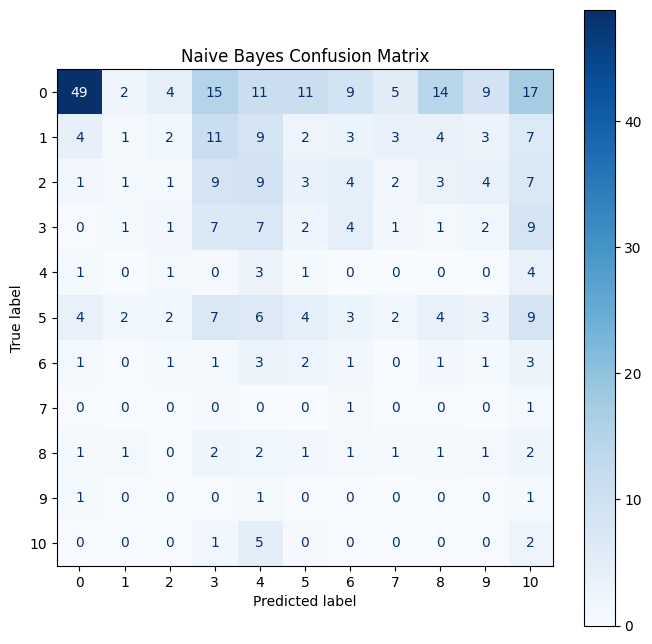

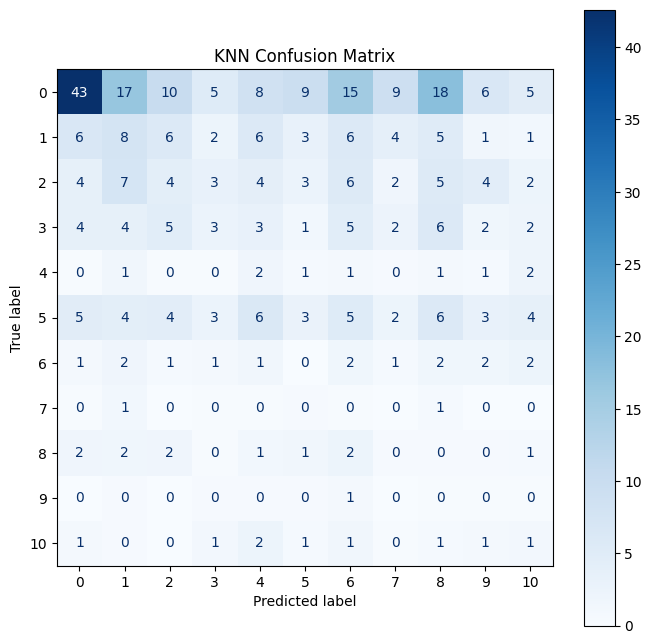

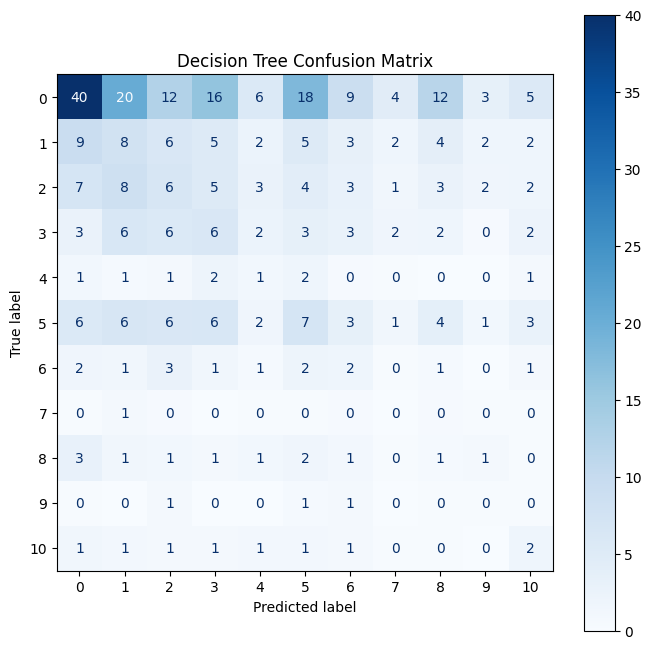

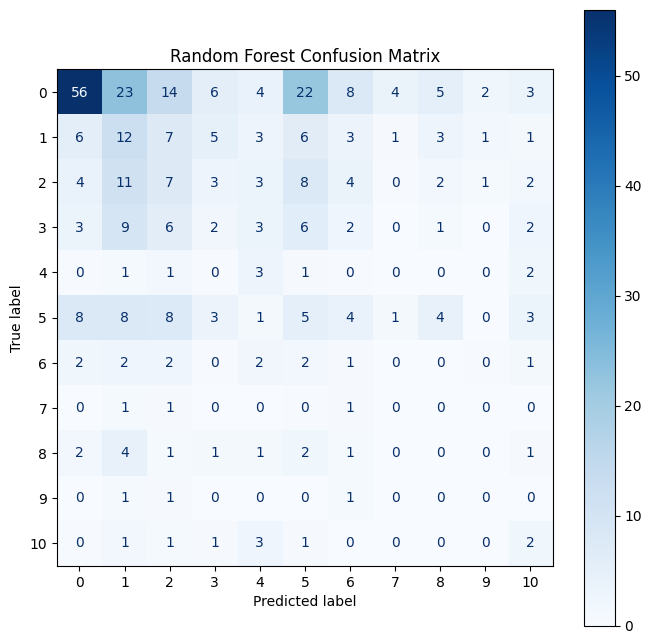

In [8]:
sum_test=np.sum(confMatrices_naiveBayes, axis=0)
sum_test=sum_test/5.0
plot_confusion_matrix(sum_test, title="Naive Bayes Confusion Matrix")

sum_test=np.sum(confMatrices_knn, axis=0)
sum_test=sum_test/5.0
plot_confusion_matrix(sum_test, title="KNN Confusion Matrix")

sum_test=np.sum(confMatrices_dTree, axis=0)
sum_test=sum_test/5.0
plot_confusion_matrix(sum_test, title="Decision Tree Confusion Matrix")


sum_test=np.sum(confMatrices_rForest, axis=0)
sum_test=sum_test/5.0
plot_confusion_matrix(sum_test, title="Random Forest Confusion Matrix")



In [9]:
del sum_test

In [10]:
#Naive Bayes
# Concatenate all DataFrames and take the mean
df_mean = pd.concat(report_dict_naiveBayes.values()).groupby(level=0).mean()
df_mean.index=["10_T02 M06 (VHM 309-12)  ", "11_T03 M06 (VHM 309-6)   ","9_T24 M06 (FRSURF50X5)   ","12_T06 M06 (VHM 309-3)   ", "13_T23 M06 (CHANF8)      ","3_T14 M06 (MECHE5.3)     ","4_T08 M06 (MECHE3.7 MD)  ","5_T09 M06 (MECHE4.6 MD)  ","6_T19 M06 (MECHE MD D4.8)","7_T10 M06 (MECHE5.5 MD)  ","8_T05 M06 (MECHE MD D5.8)", "accuracy", "macro avg", "weighted avg"]
print("Classification Report for Naive Bayes")
print(df_mean.sort_index())
del df_mean
#KNN
# Concatenate all DataFrames and take the mean
df_mean = pd.concat(report_dict_knn.values()).groupby(level=0).mean()
df_mean.index=["10_T02 M06 (VHM 309-12)  ", "11_T03 M06 (VHM 309-6)   ","9_T24 M06 (FRSURF50X5)   ","12_T06 M06 (VHM 309-3)   ", "13_T23 M06 (CHANF8)      ","3_T14 M06 (MECHE5.3)     ","4_T08 M06 (MECHE3.7 MD)  ","5_T09 M06 (MECHE4.6 MD)  ","6_T19 M06 (MECHE MD D4.8)","7_T10 M06 (MECHE5.5 MD)  ","8_T05 M06 (MECHE MD D5.8)", "accuracy", "macro avg", "weighted avg"]
print("Classification Report for KNN")
print(df_mean.sort_index())
del df_mean
#Decision Tree
# Concatenate all DataFrames and take the mean
df_mean = pd.concat(report_dict_dTree.values()).groupby(level=0).mean()
df_mean.index=["10_T02 M06 (VHM 309-12)  ", "11_T03 M06 (VHM 309-6)   ","9_T24 M06 (FRSURF50X5)   ","12_T06 M06 (VHM 309-3)   ", "13_T23 M06 (CHANF8)      ","3_T14 M06 (MECHE5.3)     ","4_T08 M06 (MECHE3.7 MD)  ","5_T09 M06 (MECHE4.6 MD)  ","6_T19 M06 (MECHE MD D4.8)","7_T10 M06 (MECHE5.5 MD)  ","8_T05 M06 (MECHE MD D5.8)", "accuracy", "macro avg", "weighted avg"]
print("Classification Report for Decision tree")
print(df_mean.sort_index())
del df_mean
#Random Forest
# Concatenate all DataFrames and take the mean
df_mean = pd.concat(report_dict_rForest.values()).groupby(level=0).mean()
df_mean.index=["10_T02 M06 (VHM 309-12)  ", "11_T03 M06 (VHM 309-6)   ","9_T24 M06 (FRSURF50X5)   ","12_T06 M06 (VHM 309-3)   ", "13_T23 M06 (CHANF8)      ","3_T14 M06 (MECHE5.3)     ","4_T08 M06 (MECHE3.7 MD)  ","5_T09 M06 (MECHE4.6 MD)  ","6_T19 M06 (MECHE MD D4.8)","7_T10 M06 (MECHE5.5 MD)  ","8_T05 M06 (MECHE MD D5.8)", "accuracy", "macro avg", "weighted avg"]
print("Classification Report for Random Forest")
print(df_mean.sort_index())
del df_mean


Classification Report for Naive Bayes
                           precision    recall  f1-score     support
10_T02 M06 (VHM 309-12)     0.802915  0.334247  0.471008  146.000000
11_T03 M06 (VHM 309-6)      0.123896  0.020833  0.035494   48.000000
12_T06 M06 (VHM 309-3)      0.055844  0.018182  0.026025   44.000000
13_T23 M06 (CHANF8)         0.126333  0.194286  0.152112   35.000000
3_T14 M06 (MECHE5.3)        0.041174  0.311111  0.072365    9.000000
4_T08 M06 (MECHE3.7 MD)     0.149728  0.093333  0.113048   45.000000
5_T09 M06 (MECHE4.6 MD)     0.042977  0.092308  0.057962   13.000000
6_T19 M06 (MECHE MD D4.8)   0.012500  0.066667  0.021053    3.000000
7_T10 M06 (MECHE5.5 MD)     0.021350  0.050000  0.029874   12.000000
8_T05 M06 (MECHE MD D5.8)   0.014286  0.066667  0.023529    3.000000
9_T24 M06 (FRSURF50X5)      0.042355  0.266667  0.072172    9.000000
accuracy                    0.188011  0.188011  0.188011    0.188011
macro avg                   0.130305  0.137664  0.097695  367.000

In [11]:
del DecisionTreeClassifier, GaussianNB, KNeighborsClassifier, RandomForestClassifier
del x_test_features, x_train_features, y_test, y_train, X_test_scaled, X_train_scaled, scaler, conf_matrix, myNpy

## Saving the results in .csv files

In [12]:
for i, matrix in enumerate(confMatrices_dTree):
    df = pd.DataFrame(matrix)
    df.to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/confusion_matrix_DTree_fold_{i+1}.csv", index=False)
for i, matrix in enumerate(confMatrices_knn):
    df = pd.DataFrame(matrix)
    df.to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/confusion_matrix_knn_fold_{i+1}.csv", index=False)
for i, matrix in enumerate(confMatrices_naiveBayes):
    df = pd.DataFrame(matrix)
    df.to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/confusion_matrix_naiveBayes_fold_{i+1}.csv", index=False)
for i, matrix in enumerate(confMatrices_rForest):
    df = pd.DataFrame(matrix)
    df.to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/confusion_matrix_rForest_fold_{i+1}.csv", index=False)


In [13]:
for i, report in enumerate(report_dict_dTree):
    report_dict_dTree[report].to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/Report_DTree_Fold_{i+1}.csv", index=True)
for i, report in enumerate(report_dict_knn):
    report_dict_knn[report].to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/Report_KNN_Fold_{i+1}.csv", index=True)
for i, report in enumerate(report_dict_naiveBayes):
    report_dict_naiveBayes[report].to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/Report_NaiveBayes_Fold_{i+1}.csv", index=True)
for i, report in enumerate(report_dict_rForest):
    report_dict_rForest[report].to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/Report_RForest_Fold_{i+1}.csv", index=True)
myResults.to_csv("F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/Results_BasicModels.csv", index=False)